# NLP Module 1 Homework
### Aleksandr Popov, ИСВЧК

## Before the start...

### Task statement 

1) Сайт http://zpp.rospotrebnadzor.ru/Forum/Appeals - скачать не менее 300 страниц (или любой другой на ваш выбор)
2) Провести предобработку текста
3) Провести тематическое моделирование. 
4) Подобровать оптимальную модель  (обосновать)
5) Подобрать  оптимальное количество топиков (coherence_metric). Визуализировать (обосновать)
4) Визуализация полученых топиков. (общий вывод)

DDL 30.10.2022 (включительно)
Сдать можно двумя способами:
1. Прислать в формате .ipynb в лс тг
2. Поделиться ссылкой на Google Colab notebook

### Materials

#### Videos:

1. [lection 1: Intro and Chatbots](https://youtu.be/A3uy8ZWkLvs)
2. lection 2: Preprocessing ([1](https://youtu.be/JRwPxHLNs2I), [2](https://youtu.be/Q-ttEgTvApk)).
3. [lection 3: Parsing and Topic modeling](https://youtu.be/GCGkDPK0ni8)
4. [lection 6: Sentiment analysis](https://www.youtube.com/watch?v=SkuOsidphL0) ([kaggle1](https://www.kaggle.com/code/ngyptr/python-nltk-sentiment-analysis/notebook) and [kaggle2](https://www.kaggle.com/code/ngyptr/lstm-sentiment-analysis-keras/notebook) for this week)

#### Articles

* [Introduction to Topic Modeling](https://monkeylearn.com/blog/introduction-to-topic-modeling/)
* [LDA](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)
* [How to compare LDA models](https://radimrehurek.com/gensim/auto_examples/howtos/run_compare_lda.html)
* `bs4`: [тут](https://towardsdatascience.com/everything-you-need-to-know-about-web-scraping-6541b241f27e) и [тут](https://habr.com/ru/post/280238/)  
* `scrappy`: [тут](https://www.kite.com/blog/python/web-scraping-scrapy/)
* `silenium`: [тут](https://habr.com/ru/post/656609/)


## Module 1 Homework Assignment



Добрый день. Текущее модульное задание было сделано с целью практики в применении методов скреппинга, нормализации и тематического моделирования для NLP. 

**Тема проекта:** you are what you listen to. Определяем музыкальный вкус по тематикам из текстов песен.  

**Мотивация проекта:** я очень люблю слушать музыку и говорить всем, что шарю за машинное обучение. Чтобы приблизить второе не отвлекаясь от первого, в прошлом году по дисциплине **Современные методы анализа данных** я проанализировал свой музыкальный вкус, основываясь на оценках `Spotify API` ([ссылка](https://github.com/alexpoov/alexpoov/blob/master/final_sp.ipynb) на проект).  
В том проекте больше всего вопросов у меня вызвала фича `valence` - мера позитивности трека. Очевидно, что метрика скорее всего является агрегацией модальности, темпа, акустичности; но в то же время на "позитивность" очень может влиять и текст (вспомним нашумевший трек *Foster the People - Pumped up Kicks*). Потому я бы хотел попрактиковаться в анализе текстовых данных песен, чтобы в будущем допилить свой проект и совместить `NLP` с `RecSys`.

> Note: в коде присутствуют очень долгие по времени выполнения чанки. Рекомендую сразу приступить к третьей главе при прогонке кода, воспользовавшись файлом `lyr_lem.csv` и бэкап-заглушкой.

In [14]:
# prerequisites 
### scrapping
import pandas as pd
from unidecode import unidecode # !pip install unidecode
from fake_useragent import UserAgent # !pip install fake_useragent 
from bs4 import BeautifulSoup    
import requests
import ssl
import re

### preprocessing 
import nltk
from pymystem3 import Mystem # !pip install pymystem3
from autocorrect import Speller # !pip install autocorrect
from string import punctuation 

### topic modeling and viz
from gensim import corpora, models # !pip install gensim
import seaborn as sb # !pip install seaborn
import matplotlib.pyplot as plt
from wordcloud import WordCloud # !pip install wordcloud
import matplotlib.pyplot as plt
import warnings

### 1. Data Scrapping

Как известно, залогом хорошего проекта по дата саенс являются интересные для пользователя данные. Поэтому в качестве данных к этому проекту я взял:
* [Spotify API](https://developer.spotify.com/documentation/web-api/), откуда выкачал историю своих прослушиваний за плюс-мину 2021 год (пакет `spotipy`; при необходимости могу скинуть код, но он не требовался в задании) 
* Сайт [Amalgama-lab](https://www.amalgama-lab.com/), содержащий переводы большинства популярных зарубежных текстов.

Лингво-лаборатория **"Амальгама"**, или **Amalgama-lab**, – проект, который появился в 2005 году под началом двух филологов и одного программиста и изначально задумывался как бюро переводов и место, где люди могли бы обучать друг друга иностранным языкам дистанционно. Постепенно специализация данного сайта сузилась до сборника текстов песен, переложенных с английского, французского, итальянского, немецкого, испанского и других языков.

Навигация по главе:  
`top` - список песен  
`extract_text()` - достать перевод песни  
`lyrics` - корпус текстов  

In [15]:
ds = pd.read_csv('stash/spotimy.csv').drop(columns='Unnamed: 0')
top = ds[['artistName', 'trackName', 'plays']].sort_values('plays', ascending=False)
top.head(15)

,artistName,trackName,plays
6696,The xx,Crystalised,82
6872,Twenty One Pilots,Heavydirtysoul,78
4535,Muse,Undisclosed Desires,77
7632,toe,グッドバイ -album version-,77
5328,Radiohead,Creep,75
6547,The Rasmus,In the Shadows,75
4732,Noize MC,Вояджер-1,74
5640,Royal Blood,Out of the Black,72
5643,Royal Blood,Ten Tonne Skeleton,70
5384,Radiohead,Reckoner,67


Структура ссылки сайта Amalgama одинакова для всех песен: `site/songs/{первая_буква_артиста}/{имя_артиста}/{имя_песни}.html`. Таким образом, мы можем создать ссылки для каждого наблюдения в датасете `top`:

In [16]:
from unidecode import unidecode  # приводим символы к ближайшему юникоду, 
# релевантно для латинских и скандинавских исполнителей, типа José González

url = []

for i, row in top.iterrows():
    
    if row['artistName'].startswith("The "):
        artist = row['artistName'].replace("The ", "").lower()
    else:
        artist = row['artistName'].lower()

    # все пробелы и тире меняем на подчерки, доллары на s (Jay-Z, A$AP Rocky)
    artist = unidecode(artist.replace(" ", "_").replace("-", "_").replace("$", 's').replace("!", ""))
    first_letter = artist[0]
    song = row['trackName'].replace(" ", "_").lower()

    url.append(f"https://www.amalgama-lab.com/songs/{first_letter}/{artist}/{song}.html")

print("Количество загатованных ссылок:", len(url))
url[:5]

Количество загатованных ссылок: 7797


['https://www.amalgama-lab.com/songs/x/xx/crystalised.html',
 'https://www.amalgama-lab.com/songs/t/twenty_one_pilots/heavydirtysoul.html',
 'https://www.amalgama-lab.com/songs/m/muse/undisclosed_desires.html',
 'https://www.amalgama-lab.com/songs/t/toe/グッドバイ_-album_version-.html',
 'https://www.amalgama-lab.com/songs/r/radiohead/creep.html']

Теперь, когда у нас есть почти 8 тысяч песен в загашнике, начнём парсить их поштучно:

In [17]:
from fake_useragent import UserAgent  
from bs4 import BeautifulSoup    
import requests
import ssl
import re

def extract_text(url):

    # для некоторых сайтов свитчить мету клиента раз в N наблюдений полезно
    UserAgent().chrome 

    # https://stackoverflow.com/questions/61631955/python-requests-ssl-error-during-requests 
    class TLSAdapter(requests.adapters.HTTPAdapter):

        def init_poolmanager(self, *args, **kwargs):
            ctx = ssl.create_default_context()
            ctx.set_ciphers('DEFAULT@SECLEVEL=1')
            kwargs['ssl_context'] = ctx
            return super(TLSAdapter, self).init_poolmanager(*args, **kwargs)


    # извлекаем все теги класса транслейт и сохраняем в лист с минимальной обработкой

    try: 

        session = requests.session()
        session.mount('https://', TLSAdapter())
        res = session.get(url)

        html = res.content
        soup = BeautifulSoup(html, 'html.parser')

        text = soup.find("div", {"id": "click_area"})

        ly = []
        for ru in text.findAll("div", {"class": "translate"}):

            # если строка пустая
            if ru.string == None:
                continue

            # если если строка повторяется (example: No [x42])
            elif re.search(r"\[(x|х)*\s?[0-9]{1,2}\s?(x|х)*\]", ru.string) != None:
                repeats = int(re.search("\d+", ru.string).group(0))
                while repeats > 0:
                    ly.append(ru.string.replace("\n", ""))
                    repeats -= 1

            # если на странице несколько вариантов перевода (записываем последний)
            elif ru.contents[0].name == "strong" and ru.contents[0]['class'][0] == "few":
                ly = []
                continue

            else:
                ly.append(ru.string.replace("\n", ""))
        
    # если ссылка не валидна или у песни нет перевода - пропускаем
    except AttributeError:
        ly = None

    return ly

Проверяем ф-цию `extract_text` на первой песне:

In [18]:
%%time
extract_text(url[0])

CPU times: total: 203 ms
Wall time: 888 ms


['Ты оказала давление,',
 'Чтобы закристаллизовать меня.',
 'И ты веришь,',
 'Что я мог бы довести до блаженства.',
 'Я прощу и забуду',
 'Прежде, чем потеряю способность двигаться.',
 'Сохранять ли мне темп,',
 'Чтобы ты оставался доволен?',
 'Все стало ближе к солнцу,',
 'И я делал все малыми дозами.',
 'Так что не думай, что я отталкиваю тебя,',
 'Когда ты — та единственная, кого я подпустил ближе всех к себе.',
 'Ты не двигаешься медленно,',
 'Предпринимая шаги в моем направлении.',
 'Звук отдается эхом.',
 'Учит ли это чему-то твою привязанность?',
 'Нет.',
 'Ты говоришь, я глупый,',
 'Что отталкиваю это от себя,',
 'Но спали дотла наш дом,',
 'Я не выберусь живым.',
 'Ледники растаяли, превратившись в море.',
 'Я хочу, чтобы течение захватило меня.',
 'Я стояла на коленях,',
 'А ты просто подбираешься все ближе.',
 'Ледники растаяли, превратившись в море.',
 '(Все стало ближе к солнцу)',
 'И я хочу, чтобы течение захватило меня.',
 '(И я делал все малыми дозами)',
 'Я стояла на к

Функция сработала на ура:
* благодаря специфике сайта, каждая строка перевода хранится в новом теге. По сути кто-то провёл токенизацию за нас заранее: стихотворные корпуса анализировать лучше всего именно по строкам. Но мы останемся с конвенциальными словами и отложим идею поэтического анализа на потом;  
* парсинг текста одной песни занимает не более секунды;  
* повторные строчки не удаляются, но дублируются столько раз, сколько надо. Это позволит не терять важные для частотных метрик (*напр. `tf_idf`*) наблюдения.

В условии задания стоит ограничение на минимум 300 текстов в корпусе. Соберём необходимое количество наблюдений:

In [19]:
%%time

### WARNING! Long execution time!

songs_to_parse = 300  # change value here
lyrics = []
is_parsed = []
i = 0

# мы вынуждены писать такой цикл, 
# потому что хотим 300 целых текстов, без пропусков

while len(lyrics) < songs_to_parse:
    text = extract_text(url[i])
    i += 1
    if text is None:
        is_parsed.append(False)
        continue
    else:
        is_parsed.append(True)
        lyrics.append(text)

print(f"{sum(is_parsed)}/{len(is_parsed)} songs parsed")

300/824 songs parsed
CPU times: total: 2min 19s
Wall time: 7min 35s


Также дополнительно был создан лист `is_parsed` класса `bool`, чтобы понять, на каких наблюдениях теряются данные:

In [20]:
top[:len(is_parsed)][[not elem for elem in is_parsed]].head(10)

,artistName,trackName,plays
7632,toe,グッドバイ -album version-,77
4732,Noize MC,Вояджер-1,74
4260,Middle Class Rut,No Sale,66
7231,YONAKA,Creature,62
6753,Tiny Little Houses,Drag Me,59
2171,Frank Carter & The Rattlesnakes,Kitty Sucker,58
6700,The xx,Intro,58
5632,Royal Blood,Limbo,56
955,CSS,City Grrrl,54
5634,Royal Blood,Look Like You Know,53


Потеря данных происходит из-за отсутствия песен на сайте. Причины:
* песни на русском языке (*Noize MC - Вояджер-1*)
* песни без слов (*The xx - Intro*)
* песни малоизвестных исполнителей (*Tinny Little House - Drag Me*)

Способы решения проблемы:
* если позволяют данные - расширить выборку. В моих 300 первых песен за один год порог прослушивания 3 раза, что достаточно много - исключает рандомные включения;
* найти другие источники переводов;
* машинный перевод ([Google Translation AI](https://cloud.google.com/translate), [Yandex Cloud Translate API](https://cloud.yandex.com/en/services/translate)) текстов ([Musixmatch](https://www.musixmatch.com/)).

### 2. Нормализация и Чистка

Вспоминаем план, рассказанный на семинарах:
0. первая чистка - когда отсеиваем совсем мусор (например из 10000 корпусов одной метки 1500 не анализируемы)  
1. нормализация - приведение слов к нормальной форме (токенизация, лемматизация)  
2. чистка: stop-words, punctuation, артикли, междометья, союзы  
3. (*) n-grams - оч классная штука

По пайплайну чистки для начала следует определиться с методами нормализации. Для выбора токенизатора я попробовал всевозможные приёмы из `nltk`: как видно из примера нижа, для большинства из них результат деления нашего текста одинаков, поэтому выбор токенизатора здесь - вкусовщина, кмк. 

In [21]:
import nltk
example_string = ' '.join(lyrics[18])  # взял строчку с переподвыпедвертом, Tame Impala - Let It Happen

ver0 = nltk.WhitespaceTokenizer()
ver0 = ver0.tokenize(example_string)
ver1 = nltk.word_tokenize(example_string)
ver2 = nltk.wordpunct_tokenize(example_string)
ver3 = nltk.tokenize.TreebankWordTokenizer()
ver3 = ver3.tokenize(example_string)

print(ver0, ver1, ver2, ver3, sep="\n\n")

['Этот', 'шум,', 'он', 'постоянно', 'окружает', 'меня', 'Но', 'он', 'не', 'так', 'громок,', 'как', 'голоса,', 'говорящие:', '"Пусть', 'это', 'произойдет,', 'пусть', 'это', 'произойдет"', '(Тебе', 'будет', 'так', 'хорошо).', 'Просто', 'дай', 'этому', 'произойти,', 'просто', 'позволь', 'этому', 'случиться.', 'Вся', 'эта', 'суета,', 'Пытающаяся', 'накрыть', 'мою', 'тень,', 'Океан,', 'растущий', 'внутри,', 'Все', 'остальные', 'кажутся', 'пустыми.', 'Вся', 'эта', 'суета', 'Ложится', 'на', 'мои', 'плечи,', 'Я', 'слышу', 'будильник,', 'Должно', 'быть,', 'уже', 'утро', 'Я', 'слышал', 'о', 'надвигающемся', 'шторме', 'Он', 'унесет', 'все', 'эти', 'оковы', 'И', 'когда', 'это', 'случится,', 'и', 'когда', 'это', 'случится', '(Я', 'буду', 'держаться)', 'Так', 'дай', 'этому', 'произойти,', 'так', 'дай', 'этому', 'произойти', 'Вся', 'эта', 'суета,', 'Я', 'больше', 'не', 'могу', 'с', 'ней', 'бороться,', 'Что-то', 'хочет', 'вырваться,', 'И', 'оно', 'близкл', 'к', 'этому', 'как', 'никогда', 'раньше', 'Ес

Дальше - формы. Почему я предпочёл лемматизацию:
1. Для богатого на чередующиеся корни и двухкорневые существительные русского языка стемминг работает не всегда чётко;  
2. Мне нравилась функциональность `mystem` в их загружаемой приложеньке, хотелось научиться пользоваться этим инструментом через питон.

In [22]:
import re
from pymystem3 import Mystem
from autocorrect import Speller
from string import punctuation 

def normalize_text(text):

    t = ' '.join(text).lower()

    # punctuation set
    punc = list(punctuation)
    punc.extend(("—", "...", "…", "])", "[(", ":]", ")."))

    # stopwords
    stop_words = nltk.corpus.stopwords.words('russian')
    stop_words.append(('это'))

    tokenizer = nltk.WordPunctTokenizer()
    spell = Speller(lang='ru')

    word_tokens = tokenizer.tokenize(t)
    filtered_sentence = [w for w in (spell(wo) for wo in word_tokens) 
                            if not w in stop_words and                # стоп-слова (от себя добавил "это")
                            w.strip() not in punc and                 # знаки препинания
                            w not in ("куплет", "припев") and         # в некоторых песнях подзаголовки
                            re.search("x*[0-9]{1,2}x*", w) == None]   # убираем иксы

    m = Mystem() # lemmatize, analyse
    lemma = m.lemmatize(' '.join(filtered_sentence))
    songtext = ''.join(lemma).split(' ')
    songtext[-1] = songtext[-1][:len(songtext[-1]) - 1]

    return songtext

Тестируем функцию:

In [23]:
%%time
normalize_text(lyrics[18])

CPU times: total: 7.23 s
Wall time: 10.5 s


['шум',
 'постоянно',
 'окружать',
 'громкий',
 'голос',
 'говорить',
 'пусть',
 'происходить',
 'пусть',
 'происходить',
 'ты',
 'просто',
 'давать',
 'это',
 'происходить',
 'просто',
 'позволять',
 'это',
 'случаться',
 'весь',
 'этот',
 'суета',
 'пытаться',
 'накрывать',
 'мой',
 'тень',
 'океан',
 'расти',
 'внутри',
 'остальной',
 'казаться',
 'пустой',
 'весь',
 'этот',
 'суета',
 'ложиться',
 'мой',
 'плечо',
 'слышать',
 'будильник',
 'должный',
 'утро',
 'слышать',
 'надвигаться',
 'шторм',
 'уносить',
 'оковы',
 'случаться',
 'случаться',
 'быть',
 'держаться',
 'давать',
 'это',
 'происходить',
 'давать',
 'это',
 'происходить',
 'весь',
 'этот',
 'суета',
 'мочь',
 'бороться',
 'хотеть',
 'вырываться',
 'оно',
 'близко',
 'это',
 'рано',
 'мой',
 'сердце',
 'останавливаться',
 'придумывать',
 'другой',
 'вернуться',
 'сказать',
 'мой',
 'мать',
 'жаль',
 'весь',
 'время',
 'готовый',
 'весь',
 'время',
 'готовый',
 'весь',
 'время',
 'готовый',
 'весь',
 'время',
 'готовы

Всё работает исправно, но лемматизация, конечно, не идеальна. От себя добавлю пару комментариев:
* песни, как и стихотворения, являются структурно специфичной величиной в текстах, так что классические приёмы для прозы тут могут быть неоптимальными;  
* учёт всех косяков (пунктуационных, например) может занять сутки;  
* в будущем я бы подкорректировал словарь слов стоп, как минимум добавив бы туда местоимения (это, тот, ты). 

In [24]:
import sys
def progressbar(it, prefix="", size=60, out=sys.stdout): # Python3.3+
    count = len(it)
    def show(j):
        x = int(size*j/count)
        print("{}[{}{}] {}/{}".format(prefix, "#"*x, "."*(size-x), j, count), 
                end='\r', file=out, flush=True)
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    print("\n", flush=True, file=out)

import time    
for i in progressbar(range(15), "Computing: ", 40):
    time.sleep(0.1) # any code you need

Computing: [########################################] 15/15



In [25]:
%%time 

# WARNING! Long execution time - примерно 30 минут >.<
import sys 

lyrics_ext = []
i = 0

for k in lyrics: 
    i += 1
    lyrics_ext.append(normalize_text(k))
    step = round(i/3, 2)
    print(f"{step}% completed")

len(lyrics_ext)

0.33% completed
0.67% completed
1.0% completed
1.33% completed
1.67% completed
2.0% completed
2.33% completed
2.67% completed
3.0% completed
3.33% completed
3.67% completed
4.0% completed
4.33% completed
4.67% completed
5.0% completed
5.33% completed
5.67% completed
6.0% completed
6.33% completed
6.67% completed
7.0% completed
7.33% completed
7.67% completed
8.0% completed
8.33% completed
8.67% completed
9.0% completed
9.33% completed
9.67% completed
10.0% completed
10.33% completed
10.67% completed
11.0% completed
11.33% completed
11.67% completed
12.0% completed
12.33% completed
12.67% completed
13.0% completed
13.33% completed
13.67% completed
14.0% completed
14.33% completed
14.67% completed
15.0% completed
15.33% completed
15.67% completed
16.0% completed
16.33% completed
16.67% completed
17.0% completed
17.33% completed
17.67% completed
18.0% completed
18.33% completed
18.67% completed
19.0% completed
19.33% completed
19.67% completed
20.0% completed
20.33% completed
20.67% compl

300

In [33]:
# backup
import csv

with open("lyr_lem.csv", "w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(lyrics_ext)

### 3. Выявляем темы

Для выделения тем я решил попробовать следующие 4 алгоритма: 
- RpModel
- LsiModel
- HdpModel
- LdaModel

На этом этапе для оценки моделей будем использовать самую прогрессивную метрику из Eye Balling Models (визуальный ручной осмотр): оценим адекватность кластеров, просто посмотрев на слова.

In [3]:
# backup

import csv
with open('lyr_lem.csv', encoding="utf-8", newline='') as f:
    reader = csv.reader(f)
    lyrics_ext = list(reader)

In [4]:
from gensim import corpora, models

dictionary = corpora.Dictionary(lyrics_ext)
corpus = [dictionary.doc2bow(text) for text in lyrics_ext]
tfidf_model = models.TfidfModel(corpus)
tfidf = tfidf_model[corpus]

In [5]:
list(tfidf)[0][:5]

[(0, 0.09646933229211863),
 (1, 0.36259011149615916),
 (2, 0.052137858650713687),
 (3, 0.06977912565601858),
 (4, 0.06977912565601858)]

#### 3.1 Latent Semantic Analysis

**Латентно-семантический анализ (LSA)** - один из наиболее часто используемых аналитиками методов тематического моделирования. Он основан на так называемой гипотезе распределения, которая утверждает, что семантику слов можно понять, рассматривая контексты, в которых они встречаются. Другими словами, согласно этой гипотезе, семантика двух слов будет схожей, если они обычно встречаются в схожих контекстах.

In [6]:
lsi = models.LsiModel(tfidf, id2word=dictionary, num_topics=3)
corpus_lsi = lsi[tfidf]
lsi.show_topics(num_words=10) # lsi.print_topics(num_words=3)[1]

[(0,
  '0.175*"хотеть" + 0.129*"все" + 0.128*"знать" + 0.127*"сказать" + 0.122*"ты" + 0.120*"мочь" + 0.116*"твой" + 0.114*"любить" + 0.106*"быть" + 0.101*"время"'),
 (1,
  '-0.509*"дух" + 0.420*"бежать" + -0.236*"спокойный" + -0.166*"познакомиться" + -0.162*"любить" + -0.155*"метать" + -0.143*"иголка" + -0.139*"приятно" + -0.138*"врать" + -0.128*"тяжелый"'),
 (2,
  '-0.410*"любить" + 0.400*"бежать" + 0.390*"дух" + 0.183*"спокойный" + 0.134*"познакомиться" + 0.120*"метать" + 0.117*"приятно" + 0.112*"врать" + 0.109*"иголка" + 0.100*"нужно"')]

#### 3.2 Hierarchical Dirichlet Process

**Иерархический процесс Дирихле (HDP)** - это непараметрический байесовский подход к кластеризации сгруппированных данных . Он использует процесс Дирихле для каждой группы данных, с процессами Дирихле для всех групп, разделяющих базовое распределение, которое, в свою очередь, основано на процессе Дирихле. Этот метод позволяет группам обмениваться статистической силой посредством разделения кластеров между группами. 

Основное преимущество, как я понял: не так сильно завязан на кол-ве кластеров.

[useful link](http://mlg.eng.cam.ac.uk/tutorials/07/ywt.pdf), [useful link 2](https://www.cs.cmu.edu/~kbe/dp_tutorial.pdf)

In [7]:
hdp = models.hdpmodel.HdpModel(tfidf, dictionary)
hdp.print_topics(num_topics=3, num_words=5)

[(0,
  '0.002*отдыхать + 0.002*ш + 0.001*верность + 0.001*домой + 0.001*старость'),
 (1,
  '0.001*жестко + 0.001*невозможно + 0.001*банально + 0.001*разброс + 0.001*требоваться'),
 (2,
  '0.001*нрав + 0.001*вглубь + 0.001*грех + 0.001*двигаться + 0.001*приступ')]

#### 3.3 Latent Dirirchlet Allocation

**Латентное распределение Дирихле (LDA)** и LSA основаны на одних и тех же исходных предположениях: гипотезе распределения (т.е. схожие темы используют схожие слова) и гипотезе статистической смеси (т.е. документы говорят о нескольких темах), для которой можно определить статистическое распределение. Цель LDA - сопоставить каждый документ в нашем корпусе с набором тем, которые охватывают большую часть слов в документе.

In [8]:
import seaborn as sb
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [9]:
lda = models.LdaModel(tfidf, id2word=dictionary, num_topics=3)

# for LDA only
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary=lda.id2word)
vis

c:\Users\popov\AppData\Local\Programs\Python\Python310\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
c:\Users\popov\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\backports.py:7: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import LooseVersion
c:\Users\popov\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.007202 -0.001067       1        1  49.092149
2      0.004644 -0.004987       2        1  27.660909
0      0.002557  0.006054       3        1  23.246942, topic_info=         Term       Freq      Total Category  logprob  loglift
425    любить  31.000000  31.000000  Default  30.0000  30.0000
3174        е  14.000000  14.000000  Default  29.0000  29.0000
836        оу  19.000000  19.000000  Default  28.0000  28.0000
8      делать  26.000000  26.000000  Default  27.0000  27.0000
57     хотеть  47.000000  47.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
46     солнце   6.602372  25.049353   Topic3  -7.4700   0.1256
313     ждать   6.718302  30.274203   Topic3  -7.4526  -0.0465
295   уходить   6.774946  33.035603   Topic3  -7.4442  -0.1254
314     жизнь   6.738722  33.697034   Topic3  -7.4496  -0.1505
540      путь   6.521295  28.002623   Topic3  -7.4824   0.0018

[219 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4377      1  0.687986          n
4377      2  0.171997          n
4377      3  0.171997          n
3268      1  0.675218  атмосфера
3268      2  0.168805  атмосфера
...     ...       ...        ...
131       2  0.318571          я
131       3  0.141587          я
2516      1  0.306718         ….
2516      2  0.230039         ….
2516      3  0.536757         ….

[489 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

### Сравнение 

#### На глаз - самые частые слова



In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
import re
warnings.filterwarnings('ignore')

def WCfromModel(model, num_words = 10, custom_title=None):

    r"\[(x|х)*\s?[0-9]{1,2}\s?(x|х)*\]"

    v_pair = re.findall(r"0\.[0-9]{3}", model.show_topics(num_words=num_words)[0][1])
    w_pair = re.findall(r'\*"?([а-я]+)"?', model.show_topics(num_words=num_words)[0][1])

    freq = {w_pair[i]: float(v_pair[i]) for i in range(min(len(v_pair), len(w_pair)))}

    wc = WordCloud(background_color="white", max_words=num_words)
    wc.generate_from_frequencies(freq)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.title(custom_title)
    plt.axis("off")
    plt.show()

>Note: Вордклауды у меня не всегда запускаются запускаются на `vscode`&`ipynb` из-за [бага](https://github.com/microsoft/vscode/issues/139609), но на анаконде или коллабе всё должно быть оки:

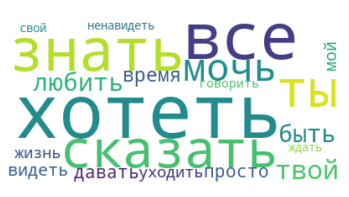

In [11]:
WCfromModel(lsi, 20, "Most frequent words: LSI")

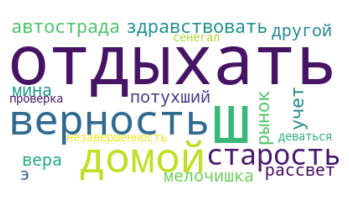

In [12]:
WCfromModel(hdp, 20, "Most frequent words: HDP")

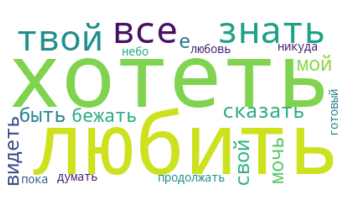

In [13]:
WCfromModel(lda, 20, "Most frequent words: LDA")

**LSI** и **LDA** успешно выделяют в один кластер эмоционально-романтические тексты, чего я и ожидал.  
В **HDP** кластеры выделились очень странно: с одной стороны слова внутри хорошо завязаны друг на друге, с другой стороны у данной модели очень низкие веса слов в кластере (предположу, что всем словам она дала плюс-минус один и тот же вес). Скорее всего, я просто неправильно построил модели и не учёл какой-то параметр.

#### По тематической согласованности
Набор утверждений или фактов называется связным, если они поддерживают друг друга (таким образом, связный набор фактов можно интерпретировать в контексте)/ C помощью `CoherenceModel` согласованность кластеров, полученных в наших моделях, можно оценить:

In [14]:
def coherence(model):
    coh_model_bw = models.CoherenceModel(model = model,
                                    texts = lyrics_ext,
                                    dictionary = dictionary,
                                    coherence = 'c_v'
                                    )
    coh_score = coh_model_bw.get_coherence()
    return coh_score

coh_lda = coherence(lda)
coh_lsi = coherence(lsi)
coh_hdp = coherence(hdp)

print(coh_lsi, coh_hdp, coh_lda, sep = "\n")

0.35087042870249313
0.7745144366535732
0.30627637581549355


Метрики согласованности подтверждают похожесть перфоманса LDA и LSI на моём копусе, потому среди них я выберу первый алгоритм как более интерпретируемый (благодаря визуализации). В качестве дополнения напишем цикл на перебор гиперпараметров и визуализируем результаты, чтобы понять оптимальное количество кластеров для тематического моделирования (хотя и оно мало что даст, скорее всего):

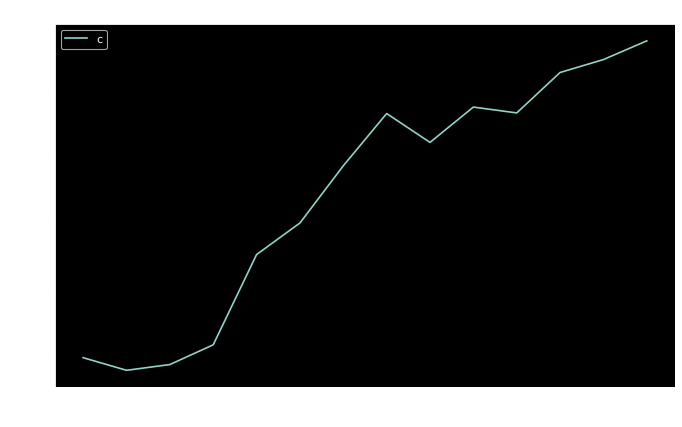

In [15]:
# можно модифицировать цикл в ф-цию и проверить для каждого алгоритмы
tuning = {k: coherence(models.LdaModel(tfidf, id2word=dictionary, num_topics=k)) for k in range(2, 16)}

plt.figure(figsize=(10, 6), dpi=80);
plt.plot(tuning.keys(), tuning.values())
plt.title("Plot of coherence metics according to number of topics if LDA")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show();

Из графика видим, что оптимальных показателей модель достигает при 9 тематиках. Дальше прирост метрики согласованности становится незначительным (если не отрицательным), да и много кластеров на руку интерпретируемости модели не сыграет. 

Финализируем нашу модель **LDA** для **9 тематик**:

In [16]:
lda = models.LdaModel(tfidf, id2word=dictionary, num_topics=9)

# for LDA only
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary=lda.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.017423  0.012198       1        1  16.563385
0     -0.007260 -0.011559       2        1  15.303107
6      0.016517 -0.002893       3        1  14.480334
1      0.001824 -0.009754       4        1  13.744787
7      0.011009  0.017466       5        1  12.936838
2     -0.003817  0.000250       6        1   8.415089
3     -0.000806 -0.002655       7        1   6.850428
4      0.000318 -0.000601       8        1   5.979992
5     -0.000362 -0.002452       9        1   5.726040, topic_info=             Term       Freq      Total Category  logprob  loglift
305        бежать  26.000000  26.000000  Default  30.0000  30.0000
836            оу  22.000000  22.000000  Default  29.0000  29.0000
67    воображение  10.000000  10.000000  Default  28.0000  28.0000
3051           ла  15.000000  15.000000  Default  27.0000  27.0000
3174            е  15.000000  15.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
621        далеко   1.979225  16.821319   Topic9  -7.2736   0.7202
436       слишком   2.067417  31.029793   Topic9  -7.2300   0.1515
590         время   2.085048  33.728758   Topic9  -7.2215   0.0766
305        бежать   1.970659  26.400271   Topic9  -7.2779   0.2651
104      понимать   1.949199  24.513566   Topic9  -7.2889   0.3283

[497 rows x 6 columns], token_table=      Topic      Freq Term
term                      
61        1  0.052727   ".
61        2  0.052727   ".
61        3  0.158181   ".
61        4  0.052727   ".
61        5  0.474542   ".
...     ...       ...  ...
2516      3  0.525655   ….
2516      4  0.065707   ….
2516      5  0.065707   ….
2516      6  0.065707   ….
2516      8  0.131414   ….

[2821 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 7, 2, 8, 3, 4, 5, 6])

**Выводы**:
* на 1, 3, 5 кластерах модель действительно выцепила какие-то интересные тематики, которые как-то намекают на общий посыл текстов;  
* разбиение на 9 кластеров кажется избыточным, так как кластеры 6-9 по сути перекрывают друг друга. Возможно оптимальнее было бы разбиение на 6 кластеров, но тогда бы мы потеряли значительную часть согласованности внутри кластеров;  
* странно, что виз сортирует слова по абсолютному idf,  а не по доле.

### Итоги

В этом проекте я попытался проанализировать свой музыкальный вкус с помощью **NLP topic modeling techniques**.

По итогу мне удалось очень сильно удариться в оптимизацию кода препроцессинга (из-за нехватки RAM сессия интераптилась трижды, теряя результаты получасового чанка), пощупать и сравнить разные алгоритмы топик моделлинга между собой и оценить их потенциал для решения подобных гипотез. Я приобрёл большее понимание значимости таких концептов, как `BoW` и `tf-idf` в контексте задач NLP.

В целом сама задумка всё ещё кажется мне перспективной. На качество конкретно данного проекта повлияли следующие факторы:  
* анализ переводов английских текстов на русский, не смотря на экспертное участие при их составлении, является маслом масленным;  
* не хватило интерпретации - например оценить вероятность вхождения каждого из текстов в конкретный кластер для определения самых ярких представителей кластеров;  
* из-за специфики моего корпуса немного не хватило данных - в стихотворных формах преобладают глаголы и местоимения, которые создавали слишком много шума в данных. Возможно данный датасет стоило приберечь до sentiment analysis'a или спарсить побольше песен (но тут смотри пункт про RAM).  
* недоразобрался с математической составляющей алгоритмов, из-за чего свёл решение к тупому сравниванию метрик разных моделей. В отличие от cross-sectional данных, тексты куда более чувствительны к процессу обучения, потому и вес принимаемых решений тут больше, и понимать надо всё лучше.